# Compute atmospheric carbon mass from 3D CO2 in CanESM5

Neil Swart, Nov 2020

Done by an oceanographer. You have been warned.

In [1]:
import numpy as np
import gcsfs
import xarray as xr
import matplotlib.pyplot as plt
import intake
%matplotlib inline
from tqdm.autonotebook import tqdm

import time

/home/ncs001/.conda/envs/py3_analysis_v1_ncs/lib/python3.6/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


## Load co2 and areacella variables

We load the data using intake, either via the CCCma data store, or external to CCCma, use the pangeo-cmip6 catalogue on google cloud.

In [2]:
cat_url = "/space/hall4/sitestore/eccc/crd/CMIP6/final/canesm_final.json" #use this inside of CCCma science net
#cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"       # use this outside of CCCma / for public data
col = intake.open_esm_datastore(cat_url)

In [3]:
query = dict(experiment_id=['esm-hist'], table_id=['Amon', 'fx'], 
             variable_id=['co2', 'ps', 'areacella'], source_id='CanESM5', member_id=['r1i1p1f1'])
cat = col.search(**query)

[data, areacella] = dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True}, 
                                storage_options={'token': 'anon'}).values()

data = data.load()


xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
                
--> There is/are 2 group(s)
[########################################] | 100% Completed |  2.0s


## Notes on calculation of carbon mass

co2 is provided:

- in units of pppmv
- on a lat-lon-pressure grid

To compute the mass of co2 (or more specifically, c) in the atmosphere, first convert from a volume to a mass mixing ratio, and then do a vertical mass-weighted integral followed by an area-weighted horizontal integral to provide the total atmospheric mass of carbon. 

The challenge is doing the mass (pressure/g) weighted integral correctly with the provided data. As is standard practise, data is provided on all pressure levels, even when they are "underground" (e.g. co2 exists at 1000 hPa over Antarctica, even though surface pressure is lower than this). Hence a direct integral will overestimate the tracer mass. To account for this, you would have to mask CO2 where `plev > ps`, where `ps` is the surface pressure and `plev` are the pressure levels on which co2 is provided. A secondary challenge is that data are reported on pressures, but the "bounds" of the pressure levels are not provided, so we have to infer them as the first derivative of the pressure levels, with the additional information that the model lid is at 1 hPa in CanESM5.

These challenges are illustrated in the plots below. 

In [42]:
# Compute the model global surface area
global_area = areacella.areacella.sum()

Text(0.5, 1.0, 'Mean historical 1000 hPa CO2 in CanESM5')

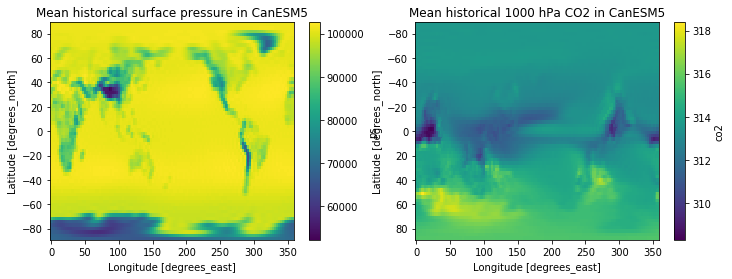

In [4]:
fig, (axl, axr)  =plt.subplots(1,2, figsize=(12,4))

(data.ps.mean(dim='time')).plot(ax=axl)
axl.set_title('Mean historical surface pressure in CanESM5')

data.co2.isel(plev=0).mean(dim=('time')).plot(ax=axr)
axr.invert_yaxis()
axr.set_title('Mean historical 1000 hPa CO2 in CanESM5')

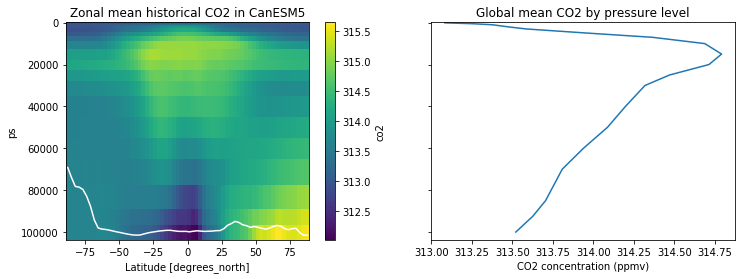

In [60]:
fig, (axl, axr)  =plt.subplots(1,2, figsize=(12,4), sharey=True)

#(data.ps.mean(dim='time')).plot(ax=axl)
#axl.set_title('Mean historical surface pressure in CanESM5')

data.co2.mean(dim=('time', 'lon')).plot(ax=axl)
data.ps.mean(dim=('time', 'lon')).plot(ax=axl, color='w')
axl.invert_yaxis()
_=axl.set_title('Zonal mean historical CO2 in CanESM5')

glob_mean_co2 = (data.co2.mean(dim=('time'))*areacella.areacella).sum(dim=['lon','lat']) / global_area
axr.plot(glob_mean_co2.squeeze().values, glob_mean_co2.plev.values)
axr.set_xlabel('CO2 concentration (ppmv)')
_=axr.set_title('Global mean CO2 by pressure level')

## Notes

- Note that co2 exists, even in regions where `ps < plev`.
- Note that CO2 only varies by about 3 ppm vertically. This is much smaller than the variations in time, in e.g. a historical experiment. Hence, using the surface mean should not be a bad approximation.

# Constants required for the calculation

In [6]:
# molecular weights of air and CO2
co2_mwg=12.010 # This is for carbon, use 44.011 for CO2 including the weight of oxygen
air_mwg=28.970 # units g/mol

# conversion of volume to mass mixing ratio. Units g/g
vmr_to_mmr = co2_mwg / air_mwg / 1.0e6 

g = 9.81 # gravitational acceleration in m/s2

## Vertical integral

Construct the mass weighting and the pressure level mask

In [7]:
# To verticall integrate co2, we need the pressure difference between levels. We also need to include the
# top, which is at 1 hPa = 10 Pa in CanESM5

plev_p1 = np.append([data.plev], 10) # append the model lid
del_plev = xr.DataArray(np.diff(plev_p1)*-1, dims='plev') # delta plev is the difference in pressure btwn levels.

In [8]:
# We need to mask the CO2 on pressure levels that are underground. To do this, construct a climatological mask, 
# for where mean surface pressure is less than the given pressure level. This could be done in a time-vaerying way,
# but since surface pressure varies by less than the difference between levels, the error in using a time-mean field
# should not be large.

#tile plev from being 1d to 2d for use in a mask
plev_2d = np.tile(data.co2.plev.values[:, np.newaxis, np.newaxis],(1,64,128))

# An array of ones, that is, use data everywhere. We will construct the mask below
unity = np.ones((19,64,128))

mask = np.ma.masked_where(plev_2d > data.ps.mean(dim='time').values, unity)

In [9]:
# finally, compute the actual mass-weighted, masked, vertical integral
vert_int_carbon = ((data.co2 * vmr_to_mmr) * del_plev / g).sum(dim='plev').compute()

# Same as the above, but apply the mask for pressure levels (basically land mask).
vert_int_carbon_masked = ((data.co2 * mask * vmr_to_mmr) * del_plev / g).sum(dim='plev').compute()

## Global atmospheric carbon mass

In [10]:
# Area-weighted global integral of atmospheric carbon, scaled from kg to Pg (/1e12)
cmass = (vert_int_carbon * areacella.areacella).sum(dim=['lon', 'lat']) / 1e12 

# the the pressure-masked version
cmass_masked = (vert_int_carbon_masked * areacella.areacella).sum(dim=['lon', 'lat']) / 1e12 

In [11]:
# Now compute the same carbon mass, but using a simple scaling factor of 2.13 Pg/ppm, and mean surface CO2
co2_surf_mean = (data.co2.isel(plev=1) * areacella.areacella).sum(dim=['lon', 'lat']) / global_area
cmass_basic = co2_surf_mean * 2.13

Text(0.5, 1.0, 'CanESM5 historical surface mean CO2 concentration')

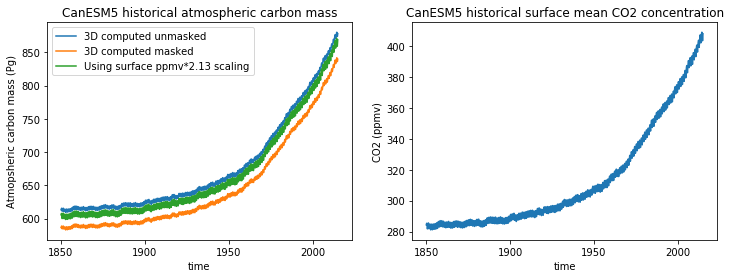

In [12]:
fig, (axl, axr)  =plt.subplots(1,2, figsize=(12,4))

cmass.plot(label='3D computed unmasked', ax=axl)
cmass_masked.plot(label='3D computed masked', ax=axl)
cmass_basic.plot(label='Using surface ppmv*2.13 scaling', ax=axl)
axl.legend()
axl.set_ylabel('Atmopsheric carbon mass (Pg)')
axl.set_title('CanESM5 historical atmospheric carbon mass')

# Plots the CO2 concentration for comparison
co2_surf_mean.plot(ax=axr)
axr.set_ylabel('CO2 (ppmv)')
axr.set_title('CanESM5 historical surface mean CO2 concentration')

### Notes

- The value estimated from the 3d fields (unmasked) is slightly higher than the version calaculated using 2.13*surface co2. 

- The masked values are a fair amount lower. This is probably because using only 19 pressure levels is too coarse, it can probably be improved by interpolating to a higher number of pressure levels. This is attempted below, and does reduce the spread.

# First order calculation


Below are some basic back of the envelope calculations of carbon mass in the atmosphere from first priniciples.

In [13]:
g = 9.81 # gravity m / s^2

# molecular weights of air and CO2
co2_mwg=12.010 # This is for carbon, use 44.011 for CO2 including the weight of oxygen
air_mwg=28.970 # g/mol

vmr_to_mmr = co2_mwg / air_mwg / 1.0e6 # This is the mass mixing ratio in units g / g

co2_ppmv = 280 # CO2 concentration in ppmv

In [14]:
#Compute surface mean pressure
ps_surf_mean = (data.ps * areacella.areacella).sum(dim=['lon', 'lat']) / global_area
pa = ps_surf_mean.mean(dim='time')

In [15]:
# Mass of the atmosphere, in kg/m2 times the global area gives ma in kg
ma = (pa / g * global_area).compute()

In [16]:
# Mass of carbon is mass * mass mixing ratio then convert from kg to Pg (/1e12)
ma * co2_ppmv * vmr_to_mmr / 1e12

<xarray.DataArray (member_id: 1)>
array([594.29254], dtype=float32)
Coordinates:
  * member_id  (member_id) <U8 'r1i1p1f1'

In [17]:
# This is the derived scaling factor to go strait from ppmv to carbon mass. This varies from 2.12 probably 
# mostly due to the atmospheric mass used, which is too high because 1013.25 hPa is the MSLP not mean surface pressure.
ma * vmr_to_mmr / 1e12 

<xarray.DataArray (member_id: 1)>
array([2.1224735], dtype=float32)
Coordinates:
  * member_id  (member_id) <U8 'r1i1p1f1'

In [18]:
# Use an observationally derived mass of 5.148e18 Kg for the atmosphere from Trenberth and Smith (2005)
5.148e18 * vmr_to_mmr / 1e12 

2.13418985157059

# Interpolated plev

Try to improve the estimate above by interpolating CO2 to a more refined pressure level grid.

In [29]:
# Use a common set of 37 plevs used in ERA, and add 1025
plev_interp = np.flipud(np.array([1, 2, 3, 5, 7, 10, 20, 30, 50, 70, 100, 125, 150, 175, 200, 225, 250, 300, 
                                  350, 400, 450, 500, 550, 600, 650, 700, 750, 775, 800, 825, 
                                  850, 875, 900, 925, 950, 975, 1000, 1025])*100.)

# Typically 44 CCCma pressure levels
plev_interp = np.flipud(np.array([1.0,1.5,2.0,3.0,5.0,7.0,10,15,20,30,50,70,80,90,100,115,125, 
                                  130,150,170,175,200,225,250,300,350,400,450,500,550,600,650,700,  
                                  750,775,800,825,850,870,900,925,950,975,1000, 1025, 1050])*100.)

# np.flipud( np.linspace(1,1025,75)*100 )

Text(0.5, 0, 'Level number')

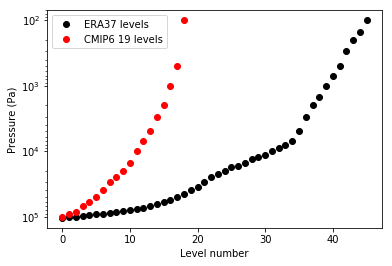

In [30]:
plt.plot(plev_interp, 'ko', label='ERA37 levels')
plt.plot(data.plev, 'ro', label='CMIP6 19 levels')
plt.yscale('log')
plt.gca().invert_yaxis()
plt.legend()
plt.ylabel('Pressure (Pa)')
plt.xlabel('Level number')

In [31]:
co2_interp = data.co2.interp(plev=plev_interp)

In [32]:
# To verticall integrate co2, we need the pressure difference between levels. We also need to include the
# top, which is at 1 hPa = 10 Pa in CanESM5

plev_p1 = np.append([plev_interp], 10) # append the model lid
del_plev = xr.DataArray(np.diff(plev_p1)*-1, dims='plev') # delta plev is the difference in pressure btwn levels.

In [72]:
# We need to mask the CO2 on pressure levels that are underground. To do this, construct a climatological mask, 
# for where mean surface pressure is less than the given pressure level. This could be done in a time-vaerying way,
# but since surface pressure varies by less than the difference between levels, the error in using a time-mean field
# should not be large.

#tile plev from being 1d to 2d for use in a mask
plev_2d = np.tile(plev_interp[np.newaxis,:, np.newaxis, np.newaxis],(1980, 1,64,128))

# An array of ones, that is, use data everywhere. We will construct the mask below
unity = np.ones((1980,len(plev_interp),64,128))

ps_tile = np.tile(data.ps.values[0,:,np.newaxis,:,:], (1,len(plev_interp),1,1))

mask = np.ma.masked_where(plev_2d > ps_tile.squeeze(), unity)

(1980, 46, 64, 128) (1980, 46, 64, 128) (1980, 46, 64, 128)


In [73]:
# finally, compute the actual mass-weighted, masked, vertical integral
vert_int_carbon = ((co2_interp * vmr_to_mmr) * del_plev / g).sum(dim='plev').compute()

# Same as the above, but apply the mask for pressure levels (basically land mask).
vert_int_carbon_masked = ((co2_interp * mask * vmr_to_mmr) * del_plev / g).sum(dim='plev').compute()

In [74]:
# Area-weighted global integral of atmospheric carbon, scaled from kg to Pg (/1e12)
cmass = (vert_int_carbon * areacella.areacella).sum(dim=['lon', 'lat']) / 1e12 

# the the pressure-masked version
cmass_masked = (vert_int_carbon_masked * areacella.areacella).sum(dim=['lon', 'lat']) / 1e12 

In [75]:
# Now compute the same carbon mass, but using a simple scaling factor of 2.122 Pg/ppm, and mean surface CO2
co2_surf_mean = (data.co2.isel(plev=1) * areacella.areacella).sum(dim=['lon', 'lat']) / global_area
cmass_basic = co2_surf_mean * 2.122

Text(0.5, 1.0, 'Anomaly from 2.122 scaling')

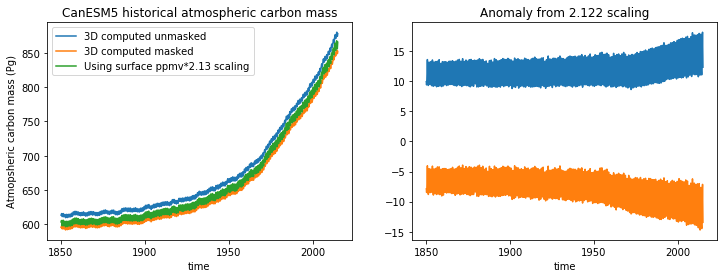

In [76]:
fig, (axl, axr)  = plt.subplots(1,2, figsize=(12,4))

cmass.plot(label='3D computed unmasked', ax=axl)
cmass_masked.plot(label='3D computed masked', ax=axl)
cmass_basic.plot(label='Using surface ppmv*2.13 scaling', ax=axl)
axl.legend()
axl.set_ylabel('Atmopsheric carbon mass (Pg)')
axl.set_title('CanESM5 historical atmospheric carbon mass')

# Plots the CO2 concentration for comparison
(cmass - cmass_basic).plot(label='3D computed unmasked', ax=axr)
(cmass_masked - cmass_basic).plot(label='3D computed masked', ax=axr)
axr.set_title('Anomaly from 2.122 scaling')

## Notes

- Divergence between the approaches is <2%.